In [1]:
from bs4 import BeautifulSoup
import urllib
from urllib.request import urlopen
from fake_useragent import UserAgent
from selenium import webdriver
import requests
import pandas as pd
import numpy as np
from textblob import TextBlob
import re
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from random import randint
%matplotlib inline

In [3]:
def recommendation_system(title,plot):
    
    movies=pd.read_csv("movies_metadata.csv")
    movies=movies.loc[:,['id','title','overview']]
    movies.loc[len(movies)]=[randint(0,10)+1000,title,plot]
    tfidf = TfidfVectorizer(stop_words='english')
    movies['overview'] = movies['overview'].fillna('')
    tfidf_matrix = tfidf.fit_transform(movies['overview'])
    similarity_distance = cosine_similarity(tfidf_matrix,tfidf_matrix)
    
    def get_recommendations(title, cosine_sim=similarity_distance):
        # Get the index of the movie that matches the title
        idx  = movies['id'][movies['title']==title].index[0]

        # Get all movies with same similarity score
        sim_scores = list(enumerate(cosine_sim[idx]))

        # Sort the movies based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the movie indices
        movie_indices = [i[0] for i in sim_scores]

        # Return the top 10 most similar movies
        return movies.iloc[movie_indices][:10]

    data=get_recommendations(title)
    
    return data

In [15]:
#Function to extract information 
def scrapper_media(imdb_link):
        
        ua = UserAgent()
        response=requests.get(imdb_link, {"User-Agent": ua.random})
        soup=BeautifulSoup(response.text,'lxml')
        
        if(re.search('https://www.imdb.com',imdb_link)):
            
            #Name
            for j in soup.select('#title-overview-widget > div.vital > div.title_block > div > div.titleBar > div.title_wrapper')[:1]:
                if(j):
                    print('Name:'+j.text.strip()[:20]+"\n\n")
                    title=j.text.strip()[:20]
                    
                    
            #Storyline
            for j in soup.select('#titleStoryLine div:nth-child(3) p span'):
                if(j):
                    print('Storyline:\n'+j.text.strip()+"\n\n")
                    plot=j.text.strip()
                
            #Rating
            for k in soup.select('#title-overview-widget div.vital div.title_block div div.ratings_wrapper div.imdbRating div strong span'):
                if(k):
                    print("Rating:"+k.text+"\n\n")
                
            #Number of Seasons
            for i in soup.select('#title-episode-widget > div > div:nth-child(4)'):
                k=i.find_all('a')
                if(k):
                    for j in k[:1]:
                        print("Number of Seasons: "+j.text.strip()+'\n')
                        
                    
            #Number of Episodes    
            for k in soup.select('#title-overview-widget > div.vital > div.button_panel.navigation_panel > a > div > div > span'):
                if(k):
                    print("Number of episodes:"+k.text.strip()[:3]+"\n")
                    
                    
            #Episode Length
            for i in soup.select('#title-overview-widget > div.vital > div.title_block > div > div.titleBar > div.title_wrapper > div > time'):
                if(i):
                    print("Episode Length:"+i.text.strip()+"\n\n")
                
            #Poster    
            content=soup.find('div',class_='poster')
            if(content):
                co=content.find('a')
                co2=co.find('img')
                response = requests.get(co2['src'])
                img = Image.open(BytesIO(response.content))
                plt.imshow(img)
                
            #Genres        
            for k in soup.select('#title-overview-widget > div.vital > div.title_block > div > div.titleBar > div.title_wrapper > div'):
                if(k):
                    q=k.find_all('a')
                    print("Genres:\n")
                    for i in q[:-1]:
                        print(i.text)
                    print('\n')
                
            #Creators and Star Cast    
            content=soup.find('div',class_='plot_summary')
            if(content):
                for i in content.find_all('div',class_='credit_summary_item'):
                    j=i.find('h4')
                    if(j):
                        if((j.text.strip()=='Creator:')|(j.text.strip()=='Creators:')):
                            w=i.find_all('a')
                            print('Creator:')
                            for s in w:
                                if(s.text.strip()=='See full cast & crew'):
                                    break
                                else:
                                    print(s.text.strip())
                            print('\n')
                        elif(j.text.strip()=='Stars:'):
                            w=i.find_all('a')
                            print('Stars:')
                            for s in w:
                                if(s.text.strip()=='See full cast & crew'):
                                    break
                                else:
                                    print(s.text.strip())
                            print('\n')
                    else:
                        print('Not Available')
                
            
            #Release Data
            for i in soup.select('#titleDetails'):
                k=i.find_all('div',class_='txt-block')
                if(k):
                    for j in k[3:4]:
                        print(j.text.strip()[:40])
                    print('\n')
                
            #Trivia And Goofs    
            content=soup.find('div',id='titleDidYouKnow')
            if(content):
                trivia=content.find('div',id='trivia')
                if(trivia):
                    print("Trivia: "+trivia.text[7:-24].strip()+"\n")
                    
                goof=content.find('div',id="goofs")
                if(goof):
                    print('Goofs: '+goof.text[6:-24].strip()+"\n")
            
    
            #People also like    
            content3=soup.find('div',class_='rec_slide')
            if(content3):
                print('People also like: \n')
                for i in content3.find_all('div',class_='rec_item'):
                    j=i.find('a')
                    k=j.find('img')
                    print(k['alt'])
                print('\n\n')
            
            
            #Reviews    
            reviews=[]
            link2=imdb_link+'reviews?ref_=tt_urv'
            response2=requests.get(link2, {"User-Agent": ua.random})
            soup2=BeautifulSoup(response2.text,'lxml')
            content2=soup2.find('div',class_='lister-list')
            
            print('User Reviews: \n')
            if(content2):
                for i in content2.find_all('div',class_='review-container'):
                    j=i.find('div',class_='content')
                    print(j.text.strip())
                    reviews.append(j.text.strip())
            
            
            #Photos
            q=[]
            for i in soup.select('#titleImageStrip > div.mediastrip'):
                k=i.find_all('a')
                if(k):
                    for j in k:
                        a=j.find('img')
                        print(a['loadlate'])
                        q.append(a['loadlate'])

                else:
                    print('Not Available')
                    
            
            #Recommendation
            c=input('Do you want to show recommended movies')
            if(c=='y'):
                df=recommendation_system(title,plot)
                print(df)
            else:
                print('Bye')
        else:
            print('Not Available')
        
        return title
    

In [5]:
def scrapper_star(imdb_link):
    
    ua = UserAgent()
    imdb_links=imdb_link[:-1]
    imdb_links2=imdb_links+'bio?ref_=nm_ov_bio_sm'
    response=requests.get(imdb_links2, {"User-Agent": ua.random})
    soup=BeautifulSoup(response.text,'lxml')
    response2=requests.get(imdb_links, {"User-Agent": ua.random})
    soup2=BeautifulSoup(response2.text,'lxml')
    
    if(re.search('https://www.imdb.com',imdb_links)):

        #Name and picture
        content=soup.find('div',class_='subpage_title_block name-subpage-header-block')
        if(content):
            a=content.find('a')
            im=a.find('img')
            k=im['src']
            response = requests.get(k)
            img = Image.open(BytesIO(response.content))
            plt.imshow(img)
                    
        #Title   
        title=content.find('div',class_='parent')
        if(title):
            print("Name: "+title.text.strip()+'\n')
            name=title.text.strip()
          

        #Overview
        content2=soup.find('table',class_='dataTable labelValueTable')
        if(content2):
            for i in content2.find_all('tr'):
                #print(":")
                j=i.text.strip()
                j=j.replace('\n'," ").replace('    ',' ')
                print(j)
            print('\n\n')
            

        #Bio
        content3=soup.find('div',class_='soda odd')
        p=content3.find('p')
        if(p):
            print(p.text.strip())
            print('\n\n')
        
        #Spouse
        content4=soup.find('table',id='tableSpouses')
        if(content4):

            for i in content4.find_all('tr'):
                j=i.find('td')
                print("Spouse: "+j.text.strip()+"\n\n")

        #Known For
        content5=soup2.find('div',id='knownfor')
        if(content5):
            print('Known For: ')
            for i in content5.find_all('div',class_='knownfor-title'):
                j=i.find('div',class_='knownfor-title-role')
                k=j.find('a')
                print(k['title'])
            print('\n\n')


        #Awards Won
        link=imdb_links+'awards?ref_=nm_awd'
        response=requests.get(link, {"User-Agent": ua.random})
        soup4=BeautifulSoup(response.text,'lxml')
        content7=soup4.find('div',class_='article listo')
        if(content7):
            q=[]
            for i in content7.find_all('table',class_='awards'):
                a=i.find_all('tr')
                for j in a:
                    k=j.find_all('td')
                    row=[w.text for w in k]
                    q.append(row)
            df=pd.DataFrame(q)
            #print(q)
            df[0]=df[0].str.replace('\n','')
            df[1]=df[1].str.replace('\n',' ')
            df[2]=df[2].str.replace('\n',' ')
            df=df[df[1].str.contains('Winner',na=False)]
            df=df.reset_index()
            df.drop('index',axis=1,inplace=True)
            df.columns=['Year','Award',"Category"]
            df['Award']=df['Award'].apply(lambda x: x[7:])
            #print(df)
            with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
                print(df)
                
            
            return name

In [6]:
def episode_guide(link):
    ua = UserAgent()
    response=requests.get(link, {"User-Agent": ua.random})
    soup=BeautifulSoup(response.text,'lxml')
    seasons=0

    for i in soup.select('#title-episode-widget > div > div:nth-child(4)'):
        k=i.find_all('a')
        if(k):
            for j in k[:1]:
                seasons=int(j.text.strip())
        else:
            seasons=0

    if(seasons):
        for i in range(seasons):
            #link='https://www.imdb.com/title/tt0903747/'
            link_=link+'episodes?season={}'.format(i)
            response=requests.get(link_, {"User-Agent": ua.random})
            soup=BeautifulSoup(response.text,'lxml')

            content=soup.find('div',class_='clear')
            season_no=content.find('h3',id='episode_top')
            print(season_no.text.strip()+'\n')

            content2=content.find('div',class_='list detail eplist')

            for j in content2.find_all('div',class_='list_item odd'):
                    title=j.find('strong')
                    title_name=title.find('a')
                    print('Episode Name: '+title_name['title']+"\t")

                    rating=j.find('div',class_='ipl-rating-widget')
                    if(rating):
                        rating_=rating.find('div',class_='ipl-rating-star small')
                        if(rating_):
                            rating_1=rating_.find('span',class_='ipl-rating-star__rating')
                            if(rating_1):
                                print('Rating: '+rating_1.text.strip()+'\t')

                    date=j.find('div',class_='airdate')
                    if(date):
                        print("Date Aired: "+date.text.strip()+'\t')

                    summary=j.find('div',class_='item_description')
                    if(summary):
                        print('Summary: '+summary.text.strip()+"\n")


            for j in content2.find_all('div',class_='list_item even'):
                    title=j.find('strong')
                    if(title):
                        title_name=title.find('a')
                        print('Episode Name: '+title_name['title']+"\t")

                    rating=j.find('div',class_='ipl-rating-widget')
                    if(rating):
                        rating_=rating.find('div',class_='ipl-rating-star small')
                        if(rating_):
                            rating_1=rating_.find('span',class_='ipl-rating-star__rating')
                            if(rating_1):
                                print('Rating: '+rating_1.text.strip()+'\t')

                    date=j.find('div',class_='airdate')
                    if(date):
                        print("Date Aired: "+date.text.strip()+'\t')

                    summary=j.find('div',class_='item_description')
                    if(summary):
                        print('Summary: '+summary.text.strip()+"\n")

    else:
        print('No guide as it is a movie')


In [7]:
def link_extract(name):
    query = name
    
    query = urllib.parse.quote_plus(query) # Format into URL encoding
    number_result = 1
    ua = UserAgent()
    google_url = "https://www.google.com/search?q=" + query +"imdb"+"&num=" + str(number_result)
    response = requests.get(google_url, {"User-Agent": ua.random})
    soup = BeautifulSoup(response.text, "html.parser")
    result_div = soup.find_all('div', attrs = {'class': 'ZINbbc'})
    for r in result_div:
        # Checks if each element is present, else, raise exception
        try:
            link = r.find('a', href = True)
            title = r.find('div', attrs={'class':'vvjwJb'}).get_text()
            #description = r.find('div', attrs={'class':'s3v9rd'}).get_text()
            # Check to make sure everything is present before appending
            if link != '':
                imdb_links=link['href'][7:44]
                #print(imdb_links)
                #titles.append(title)
                #descriptions.append(description)
                # Next loop if one element is not present
                break
        except:
            continue
    return imdb_links


In [10]:
#Run only once if files are not created
data_media={}
data_star={}
df_media=pd.DataFrame(columns=['Movie or Show name','Number of Searches'])
df_star=pd.DataFrame(columns=['Actor Name','Number of Searches'])

In [13]:
data_media = json.load(open("data_media.txt"))
data_star = json.load(open("data_star.txt"))
df_media=pd.read_csv('df_media.csv')
df_star=pd.read_csv('df_star.csv')
df_media.drop('Unnamed: 0',axis=1,inplace=True)
df_star.drop('Unnamed: 0',axis=1,inplace=True)

Media(m) or Star(s)m
Enter Name: interstellar
Name:Interstellar (2014) 


Storyline:
Earth's future has been riddled by disasters, famines, and droughts. There is only one way to ensure mankind's survival: Interstellar travel. A newly discovered wormhole in the far reaches of our solar system allows a team of astronauts to go where no man has gone before, a planet that may have the right environment to sustain human life.


Rating:8.6


Episode Length:2h 49min


Genres:

Adventure
Drama
Sci-Fi


Stars:
Matthew McConaughey
Anne Hathaway
Jessica Chastain


Release Date: 7 November 2014 (India)
  


Trivia: According to Dr. Kip Thorne, the largest degree of creative license in this movie are the clouds of the ice planet, which are structures that probably go beyond the material strength which ice would be able to support.

Goofs: During the emergency attempt to dock with the spinning Endurance, CASE informs Cooper that the Endurance is hitting the stratosphere of the planet below, with Br

Do you want to show recommended moviesy


C:\Users\asus\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


           id                 title  \
45466    1007  Interstellar (2014)    
22879  157336          Interstellar   
42701  441043               Asteria   
10882    8410  The Wild Blue Yonder   
44211   28590         King Dinosaur   
11732    1272              Sunshine   
31669  286657          Crawl or Die   
18995   70981            Prometheus   
32610   21836        Humanity's End   
42024  109213         The Zero Boys   

                                                overview  
45466  Earth's future has been riddled by disasters, ...  
22879  Interstellar chronicles the adventures of a gr...  
42701  Two astronauts attempt to plant their flag on ...  
10882  An alien narrates the story of his dying plane...  
44211  Four astronauts in 1960 travel to a planet cal...  
11732  Fifty years into the future, the sun is dying,...  
31669  Earth as we know it is gone. A virus has destr...  
18995  A team of explorers discover a clue to the ori...  
32610  The year is 3313. Mankind is bei

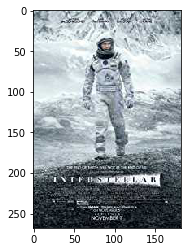

In [16]:
scrapper=input('Media(m) or Star(s)')
if(scrapper=='m'):
    name=input('Enter Name: ')
    imdb_link=link_extract(name)
    
    if(data_media.get(name)==None):
        imdb_link=link_extract(name)
        data_media[name]=imdb_link        
        title=scrapper_media(imdb_link)
        df_media.loc[len(df_media)]=[title,1]
        c=input('Want the episode guide (y/n)')
        if(c=='y'):
            episode_guide(imdb_link)
        else:
            print('Bye')
    else:
        imdb_link=data_media[name]
        title=scrapper_media(imdb_link)
        df_media['Number of Searches'][df_media['Movie or Show name']==title]+=1
        c=input('Want the episode guide (y/n)')
        if(c=='y'):
            episode_guide(imdb_link)
        else:
            print('Bye')
        
elif(scrapper=='s'):
    name=input('Enter Name: ')
    if(data_star.get(name)==None):
        imdb_link=link_extract(name)
        data_star[name]=imdb_link        
        name_1=scrapper_star(imdb_link)
        df_star.loc[len(df_star)]=[name_1,1]
    else:
        imdb_link=data_star[name]
        name_1=scrapper_star(imdb_link)
        df_star['Number of Searches'][df_star['Actor Name']==name_1]+=1
        
elif(scrapper=='e'):
    print('Bye..')
    #break
else:
    print('wrong input')
    #break

In [17]:
json.dump(data_media, open("data_media.txt",'w'))

json.dump(data_star, open("data_star.txt",'w'))

df_media.to_csv('df_media.csv')

df_star.to_csv('df_star.csv')

In [18]:
df_media = pd.pivot_table(df_media, index=['Movie or Show name'],values=['Number of Searches'],aggfunc='sum')
df_media=df_media.reset_index()
df_star = pd.pivot_table(df_star, index=['Actor Name'],values=['Number of Searches'],aggfunc='sum')
df_star=df_star.reset_index()

In [21]:
df_media

,Movie or Show name


In [22]:
df_star

,Actor Name
